### Importy

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

### Wczytanie danych

In [20]:
df = pd.read_csv("../data/final_data.csv", delimiter=';')
df.drop(columns=["id"], inplace=True)

### Dodatkowa analiza rozkładów i outlierów
Cel: Zidentyfikować i zrozumieć, które obserwacje ekstremalne (ceny > pewien próg) wypaczają odchylenie standardowe i R².

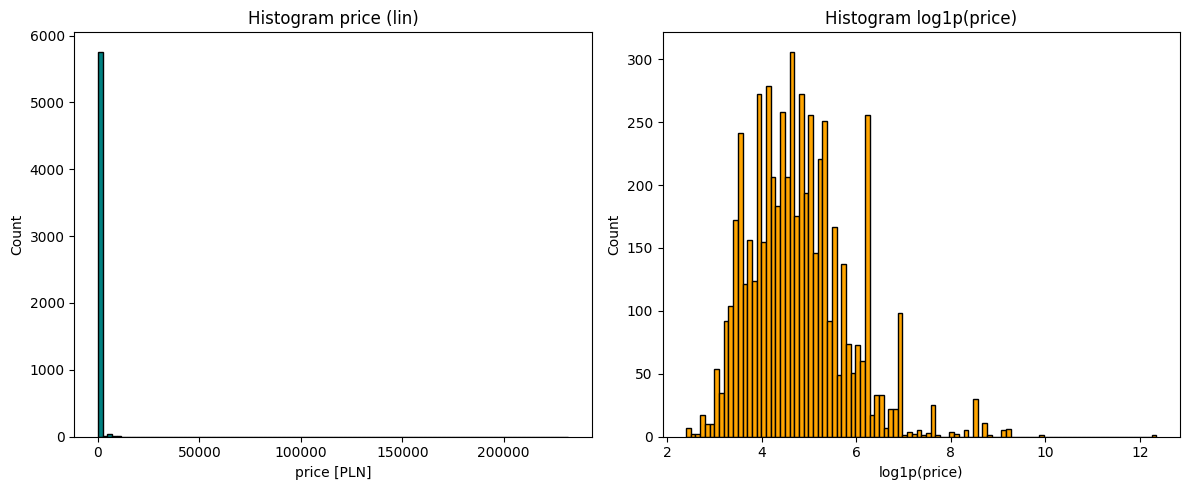

Price > 50 PLN: 76.47% obserwacji
Price > 100 PLN: 49.31% obserwacji
Price > 200 PLN: 23.62% obserwacji
Price > 300 PLN: 15.19% obserwacji
Price > 400 PLN: 11.72% obserwacji
Price > 500 PLN: 7.64% obserwacji
Price > 1000 PLN: 1.91% obserwacji
Price > 2000 PLN: 1.15% obserwacji
Price > 5000 PLN: 0.43% obserwacji


In [21]:
#Histogram cen w skali liniowej i logarytmicznej
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=100, color='teal', edgecolor='black')
plt.title('Histogram price (lin)')
plt.xlabel('price [PLN]')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['price']), bins=100, color='orange', edgecolor='black')
plt.title('Histogram log1p(price)')
plt.xlabel('log1p(price)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Proporcja ofert powyżej różnych progów
for threshold in [50, 100, 200, 300, 400, 500, 1000, 2000, 5000]:
    pct = (df['price'] > threshold).mean() * 100
    print(f"Price > {threshold} PLN: {pct:.2f}% obserwacji")

### Korelacje cech z log1p(price) i wybór Top 50
Wytypowanie tych cech, które rzeczywiście silnie korelują z ceną – tak, aby nie trenować sieci na wszystkich ~190 kolumnach, tylko skupić się na 50–60 najbardziej znaczących atrybutach. Dzięki temu:

- Mniejsza liczba wejściowych zmiennych da mniej parametrów w sieci → szybsze trenowanie i mniejsze ryzyko overfittingu.

- Sieć nie będzie “rozpraszać się” na cechy niemające realnego wpływu na cenę.

Top 50 cech o najwyższej korelacji z log1p(price):
accommodates                        0.530
property_type_Private room in rental unit 0.507
room_type_Private room              0.468
room_type_Entire home/apt           0.449
property_type_Entire rental unit    0.404
bedrooms                            0.379
bathroom_type_shared                0.373
bathroom_type_unknown               0.324
amenity_Dishwasher                  0.317
amenity_Hair dryer                  0.306
instant_bookable                    0.292
amenity_Air conditioning            0.288
amenity_Lock on bedroom door        0.282
amenity_Crib                        0.274
beds                                0.261
amenity_Oven                        0.250
amenity_Hot water kettle            0.229
amenity_Toaster                     0.226
amenity_Microwave                   0.220
amenity_Coffee maker                0.219
amenity_Iron                        0.218
amenity_Bed linens                  0.217
amenity_Refrigerato

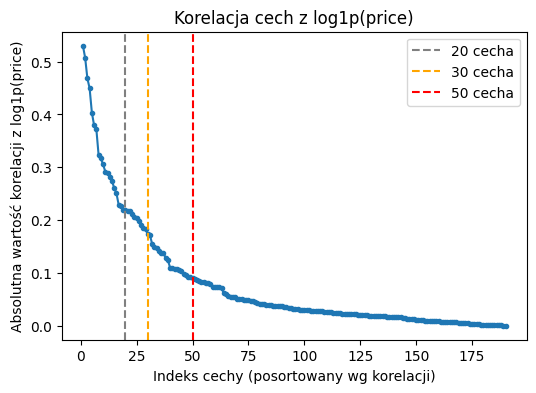

In [22]:
# Najpierw zapewniamy, że cena jest w logarytmie, bo rozkład jest mocno skośny:
price_log = np.log1p(df["price"])

# Obliczamy korelację bezwzględną każdej cechy z log1p(price)
# (pomijamy kolumny, których nie chcemy brać pod uwagę, np. 'id', samą 'price' czy 'is_premium')
corrs = []
for col in df.columns:
    if col in ["id", "price", "is_premium"]:
        continue
    # bierzemy tylko cechy numeryczne (float lub int)
    if pd.api.types.is_numeric_dtype(df[col]):
        # obliczamy korelację Pearsona między df[col] a price_log
        c = np.corrcoef(df[col], price_log, rowvar=False)[0, 1]
        corrs.append((col, abs(c)))

# Sortujemy według wartości korelacji malejąco i wyświetlamy top 20
corrs_sorted = sorted(corrs, key=lambda x: x[1], reverse=True)

print("Top 50 cech o najwyższej korelacji z log1p(price):")
for col, cval in corrs_sorted[:50]:
    print(f"{col:<35} {cval:.3f}")

# Następnie wybieramy, powiedzmy, Top 50 najbardziej skorelowanych cech
top_k = [col for col, _ in corrs_sorted[:50]]
print(f"\nWybrano {len(top_k)} cech jako Top 50.")

# Zapiszmy je do zmiennej X (będziemy trenować na tych cechach)
X = df[top_k].copy()

# A target (y) to log1p(price) (ew. price, jeśli będziesz trenować na surowych wartościach)
y = price_log.copy()

# Sprawdźmy rozmiary:
print("\nKształt X:", X.shape)
print("Kształt y:", y.shape)

# Przygotuj listę samych wartości korelacji w kolejności malejącej:
corr_values = [c for _, c in corrs_sorted]

plt.figure(figsize=(6,4))
plt.plot(range(1, len(corr_values)+1), corr_values, marker='o', markersize=3)
plt.axvline(20, color='gray', linestyle='--', label='20 cecha')
plt.axvline(30, color='orange', linestyle='--', label='30 cecha')
plt.axvline(50, color='red', linestyle='--', label='50 cecha')
plt.xlabel('Indeks cechy (posortowany wg korelacji)')
plt.ylabel('Absolutna wartość korelacji z log1p(price)')
plt.title('Korelacja cech z log1p(price)')
plt.legend()
plt.show()



### Opcje dla outlierów: segmentacja lub ważenie
Cel: Zdecydować, czy tworzyć osobne podejście dla „premium” ofert, czy ważyć stratę tak, by model zwracał większą uwagę na drogie ogłoszenia

In [23]:
# Definiujemy próg premium – na przykład >1000 PLN
premium_threshold = 1000

df['is_premium'] = (df['price'] > premium_threshold).astype(int)

print("Liczba premium ofert (>1000 PLN):", df['is_premium'].sum(), "/", len(df))
print(f"Udział: {df['is_premium'].mean() * 100:.2f}%")

Liczba premium ofert (>1000 PLN): 111 / 5826
Udział: 1.91%
